# process forcing fields for PAR

PAR just below sea ice (${PAR}_{ice}$) is in PAR_iceFile.

PAR just below open water (${PAR}_{ow}$) is in PARFile.

In [1]:
import matplotlib.pyplot as plt
import netcdf_tools
import numpy as np
import sys

In [2]:
ndays=365

## process forcing fields for ${PAR}_{ice}$

input file: GE_mod_var.nc.

long_name: solar_heat_flux_under_ice_for_100:100_ice_cover.

standard_name in NEMO: surface_downwelling_shortwave_in water.

Variable solar_heat_flux_under_ice_for_100:100_ice_cover is the surface
downwelling shortwave in water (below ice for 100% ice cover).
It is at indices (2,2) meaning center of grid point was used.
File GE_mod_var.nc is the output of NEMO3.6+LIM3.6 model configured 
by Gaetan Olivier (UBO) for the Green Edge ice camp 2016
(67.48N, -63.79E).

### daily shortwave radiation just below sea ice from 2013 to 2017

In [3]:
qswice_file='GE_mod_var.nc'
array1d_iT_qswicefull=netcdf_tools.read_netcdf(qswice_file,'solar heat flux under ice for 100:100 ice cover')
array1d_iT_qswicefull=array1d_iT_qswicefull[:,2,2]

### daily shortwave radiation just below sea ice from 2016

In [4]:
array1d_idoy_qswice=array1d_iT_qswicefull[365*3:365*4]

### daily PAR just below sea ice in 2016

In [5]:
Wm2_to_PAR=0.85 # Lebrun et al. (submitted)
array1d_idoy_PARice=array1d_idoy_qswice*Wm2_to_PAR

### daily irradiance of each 3 RGB bands just below sea ice in 2016

in $W m^{-2}$

In [6]:
# Lebrun et al. (submitted). Values for the Green Edge ice camp 2016.
blue_fraction =0.43
green_fraction=0.46
red_fraction =0.11
array1d_idoy_blueWm2 =array1d_idoy_PARice*blue_fraction
array1d_idoy_greenWm2=array1d_idoy_PARice*green_fraction
array1d_idoy_redWm2  =array1d_idoy_PARice*red_fraction

### daily irradiance of each 3 RGB bands just below sea ice in 2016

in $\mu mol\ photons\ m^{-2}\ s^{-1}$

ref: https://gud.mit.edu/MITgcm/source/pkg/gud/gud_radtrans_direct.F?v=gud

In [7]:
rmus=1/0.83
planck = 6.6256e-34  # Plancks constant J sec
c = 2.998e8          # speed of light m/sec
hc = 1.0/(planck*c)
oavo = 1.0/6.023e23  # 1/Avogadros number
hcoavo = hc*oavo
wb_center=np.array([450,550,650]) # [blue, green, red]
rlamm=wb_center*1e-9 # lambda in m
WtouEins=1e6*rlamm*hcoavo
array1d_idoy_blue =array1d_idoy_blueWm2 *WtouEins[0]
array1d_idoy_green=array1d_idoy_greenWm2*WtouEins[1]
array1d_idoy_red  =array1d_idoy_redWm2  *WtouEins[2]

### daily PAR just below sea ice in 2016

In [8]:
array1d_idoy_PARiceuEin=array1d_idoy_blue+array1d_idoy_green \
+array1d_idoy_red
array1d_idoy_PARiceuEin=array1d_idoy_PARiceuEin.squeeze()

### 1D_NEMO_PARice_y2016.365.32bits.bin

In [9]:
PARicefile='1D_NEMO_PARice_y2016.365.32bits.bin'
array1d_idoy_PARiceuEin=np.nan_to_num(array1d_idoy_PARiceuEin)
if ~array1d_idoy_PARiceuEin.mask:
    array1d_idoy_PARiceuEin.compressed().astype('>f4').tofile(PARicefile)
array1d_idoy_PARiceuEin=np.fromfile(PARicefile,dtype='>f4')

### plot

In [10]:
first_year=np.arange(0,ndays)

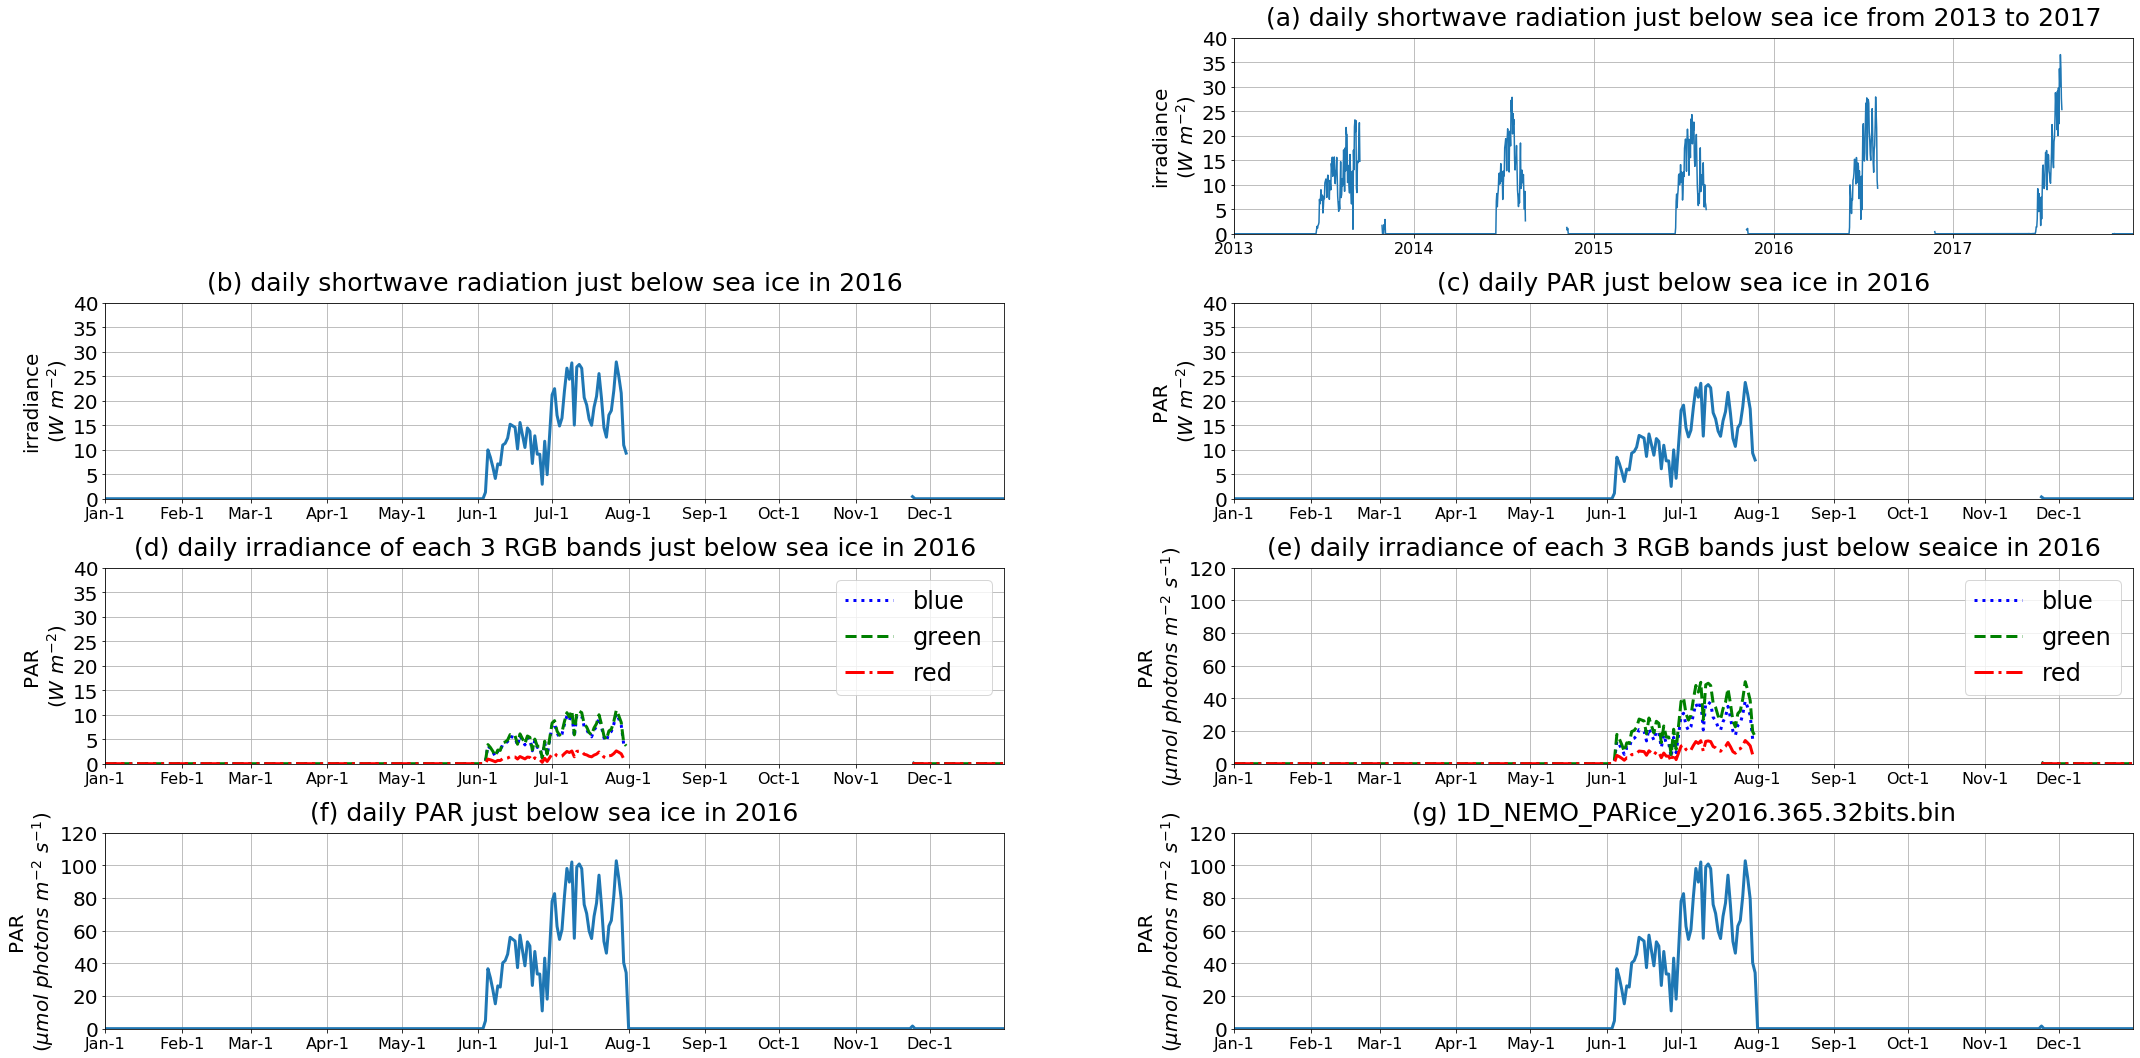

In [11]:
with plt.style.context('GEic2016.m3.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    fig,axs=plt.subplots(nrows=4,ncols=2,figsize=(32, 16))
    
    # --- BLANK
    ax=axs[0,0]
    ax.axis('off')
    
    # --- DAILY SHORTWAVE RADIATION JUST BELOW SEA ICE FROM 2013 TO 2016
    ax=axs[0,1]
    ax.plot(np.arange(0,ndays*5),
           array1d_iT_qswicefull)
    ax.set_ylabel('irradiance\n'\
                  '($W\ m^{-2})$')
    ax.set_xlim(0,ndays*5-1)
    ax.set_ylim(0,40)
    ax.grid()
    ax.set_xticks(np.arange(0,ndays*5,ndays))
    ax.set_xticklabels(np.arange(2013,2018))
    plt.text(0.50,1.10,
             '(a) daily shortwave radiation just below sea ice from '\
             '2013 to 2017',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY SHORTWAVE RADIATION JUST BELOW SEA ICE FROM 2016
    ax=axs[1,0]
    ax.plot(first_year,array1d_idoy_qswice,lw=3)
    ax.set_ylabel('irradiance\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,40)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(b) daily shortwave radiation just below sea ice in '\
             '2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW SEA ICE IN 2016
    # --- W m^-2
    ax=axs[1,1]
    ax.plot(first_year,array1d_idoy_PARice,lw=3)
    ax.set_ylabel('PAR\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,40)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(c) daily PAR just below sea ice in '\
             '2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW SEA ICE IN 2016
    # --- W m^-2
    ax=axs[2,0]
    ax.plot(first_year,array1d_idoy_blueWm2,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_greenWm2,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_redWm2,
                  '-.',color='red',lw=3,label='red')
    ax.legend(fontsize=24)
    ax.set_ylabel('PAR\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,40)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(d) daily irradiance of each 3 RGB bands just below sea '\
             'ice in 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW SEA ICE IN 2016
    # --- umol photons m^-2 s^-1
    # ref: https://gud.mit.edu/MITgcm/source/pkg/gud/gud_radtrans_direct.F?v=gud
    ax=axs[2,1]
    ax.plot(first_year,array1d_idoy_blue,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_green,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_red,
                  '-.',color='red',lw=3,label='red')
    ax.legend(fontsize=24)
    ax.set_ylabel('PAR\n'\
                  '$(\mu mol\ photons\ m^{-2}\ s^{-1})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,120)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(e) daily irradiance of each 3 RGB bands just below sea'\
             'ice in 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW SEA ICE IN 2016
    # --- umol photons m^-2 s^-1
    ax=axs[3,0]
    ax.plot(first_year,array1d_idoy_PARiceuEin,lw=3)
    ax.set_ylabel('PAR\n'\
                  '$(\mu mol\ photons\ m^{-2}\ s^{-1})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,120)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(f) daily PAR just below sea ice in 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- 1D_NEMO_PARice_y2016.365.32bits.bin
    ax=axs[3,1]
    ax.plot(first_year,array1d_idoy_PARiceuEin,lw=3)
    ax.set_ylabel('PAR\n'\
                  '$(\mu mol\ photons\ m^{-2}\ s^{-1})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,120)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(g) 1D_NEMO_PARice_y2016.365.32bits.bin',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- POSITION
    axs[0,0].set_position( [0.05,0.74  ,0.39,0.17])
    axs[0,1].set_position( [0.54,0.74  ,0.39,0.17])
    axs[1,0].set_position( [0.05,0.51  ,0.39,0.17])
    axs[1,1].set_position( [0.54,0.51  ,0.39,0.17])
    axs[2,0].set_position( [0.05,0.28  ,0.39,0.17])
    axs[2,1].set_position( [0.54,0.28  ,0.39,0.17])
    axs[3,0].set_position( [0.05,0.05  ,0.39,0.17])
    axs[3,1].set_position( [0.54,0.05  ,0.39,0.17])
    

    
    # --- SAVE
    plt.savefig('PARice_processing_NEMO.png')

## process forcing fields for $PAR_{ow}$

input file: 1D_GDPS_qsw_y2016.nc

name: qsw

Variable qsw is the shortwave radiation just above surface.
It is at indices (2,2) meaning center of grid point was used.
File 1D_GDPS_qsw_y2016.nc is the output of CMC GDPS reforecasts (CGRF).
CMC: Canadian Meteorological Centre's.
GDPS: global deterministic prediction system.
The data was provided by Gregory Smith (Environment Canada).
Gaetan Olivier (UBO) preprocessed it to get the data at the Green Edge 2016 ice camp (67.48N, -63.79E).

### hourly shortwave radiation just above surface in 2016

In [12]:
qswow_file='1D_GDPS_qsw_y2016.nc'
array1d_iT_qswowabovehourly=netcdf_tools.read_netcdf(qswow_file,'qsw')
array1d_iT_qswowabovehourly=array1d_iT_qswowabovehourly[:,2,2]

### daily shortwave radiation just above surface in 2016

In [13]:
array1d_idoy_qswowabove=np.zeros(ndays)
for idoy in first_year:
    qswowabovedaily=0
    for iT in np.arange(idoy*24,(idoy+1)*24):
        qswowabovedaily=qswowabovedaily+array1d_iT_qswowabovehourly[iT]
    qswowabovedaily=qswowabovedaily/24
    array1d_idoy_qswowabove[idoy]=qswowabovedaily

### daily shortwave radiation just below open water in 2016

In [14]:
albedo=0.066 # model PISCES, ref.: Aumont et al. (2015)
array1d_idoy_qswow=array1d_idoy_qswowabove*(1-albedo)

### daily PAR just below open water in 2016

In [15]:
Wm2_to_PAR=0.43 # model PISCES, ref.: Aumont et al. (2015)
array1d_idoy_PARow=array1d_idoy_qswow*Wm2_to_PAR

In [16]:
### daily irradiance of each 3 RGB bands just below open water in 2016

in $W m^{-2}$

In [17]:
onecolor=1/3
array1d_idoy_blueWm2ow=array1d_idoy_PARow*onecolor
array1d_idoy_greenWm2ow=array1d_idoy_PARow*onecolor
array1d_idoy_redWm2ow=array1d_idoy_PARow*onecolor

### daily irradiance of each 3 RGB bands just below open water in 2016

in $\mu mol\ photons\ m^{-2}\ s^{-1}$

ref: https://gud.mit.edu/MITgcm/source/pkg/gud/gud_radtrans_direct.F?v=gud

In [18]:
array1d_idoy_blueow =array1d_idoy_blueWm2ow *WtouEins[0]
array1d_idoy_greenow=array1d_idoy_greenWm2ow*WtouEins[1]
array1d_idoy_redow  =array1d_idoy_redWm2ow  *WtouEins[2]

### daily PAR just below open water in 2016

In [19]:
array1d_idoy_PARowuEin=array1d_idoy_blueow+array1d_idoy_greenow+array1d_idoy_redow

### 1D_GDPS_PAR_y2016.365.32bits.bin

In [20]:
PARowfile='1D_GDPS_PAR_y2016.365.32bits.bin'
array1d_idoy_PARowuEin.astype('>f4').tofile(PARowfile)
array1d_idoy_PARowuEin=np.fromfile(PARowfile,dtype='>f4')

### plot

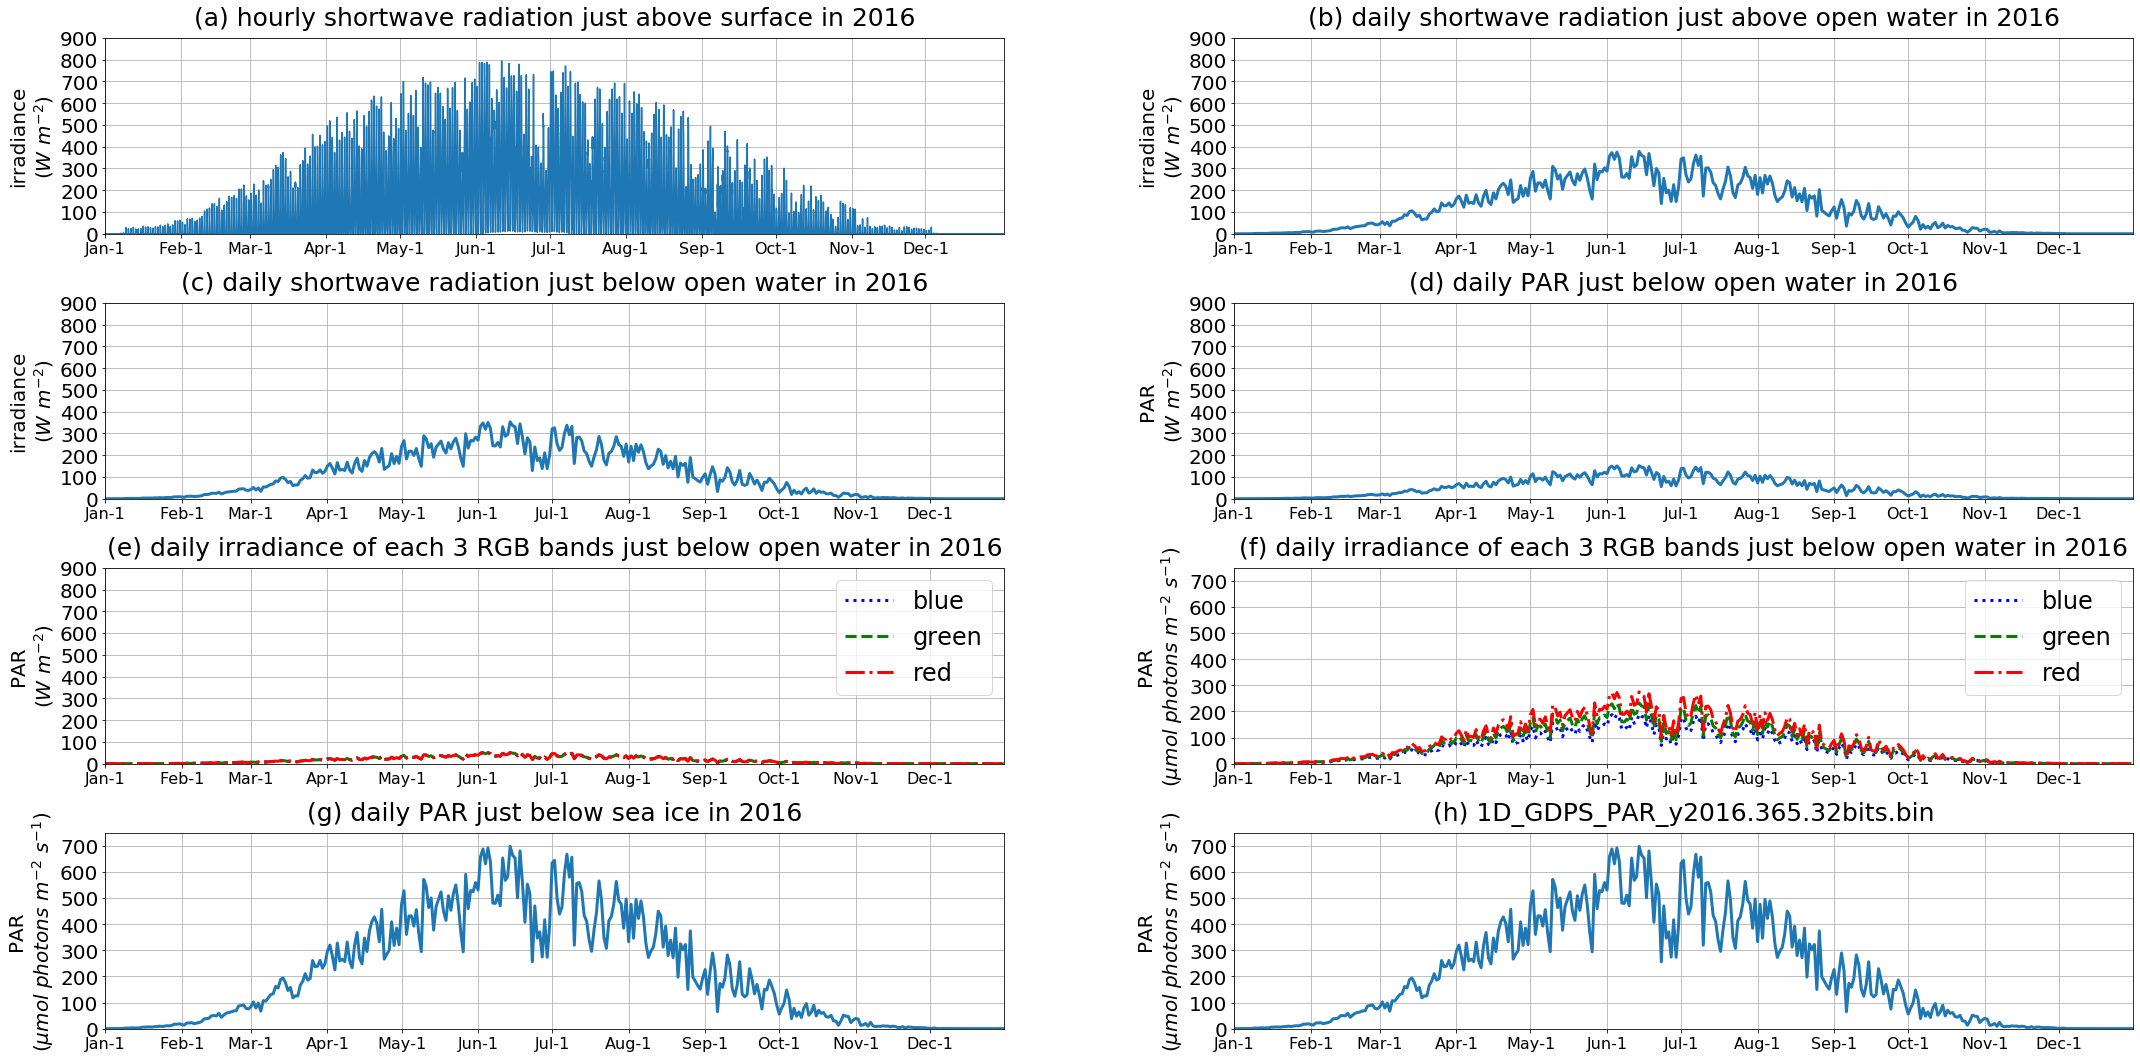

In [21]:
with plt.style.context('GEic2016.m3.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    fig,axs=plt.subplots(nrows=4,ncols=2,figsize=(32, 16))
    
    # --- HOURLY SHORTWAVE RADIATION JUST ABOVE SURFACE IN 2016
    ax=axs[0,0]
    ax.plot(np.arange(0,(ndays+1)*24),array1d_iT_qswowabovehourly)
    ax.set_ylabel('irradiance\n'\
                  '($W\ m^{-2})$')
    ax.set_xlim(0,(ndays+1)*24-1)
    ax.set_ylim(0,900)
    ax.grid()
    ax.set_xticks(locs*24)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(a) hourly shortwave radiation just above surface in 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY SHORTWAVE RADIATION JUST ABOVE SURFACE IN 2016
    ax=axs[0,1]
    ax.plot(first_year,array1d_idoy_qswowabove,lw=3)
    ax.set_ylabel('irradiance\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,900)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(b) daily shortwave radiation just above open water in 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY SHORTWAVE RADIATION JUST BELOW OPEN WATER IN 2016
    ax=axs[1,0]
    ax.plot(first_year,array1d_idoy_qswow,lw=3)
    ax.set_ylabel('irradiance\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,900)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(c) daily shortwave radiation just below open water in 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW OPEN WATER IN 2016
    # --- W m^-2
    ax=axs[1,1]
    ax.plot(first_year,array1d_idoy_PARow,lw=3)
    ax.set_ylabel('PAR\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,900)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(d) daily PAR just below open water in 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW OPEN WATER IN 2016
    # --- W m^-2
    ax=axs[2,0]
    ax.plot(first_year,array1d_idoy_blueWm2ow,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_greenWm2ow,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_redWm2ow,
                  '-.',color='red',lw=3,label='red')
    ax.legend(fontsize=24)
    ax.set_ylabel('PAR\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,900)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(e) daily irradiance of each 3 RGB bands just below open '\
             'water in 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW OPEN WATER IN 2016
    # --- umol photons m^-2 s^-1
    ax=axs[2,1]
    ax.plot(first_year,array1d_idoy_blueow,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_greenow,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_redow,
                  '-.',color='red',lw=3,label='red')
    ax.legend(fontsize=24)
    ax.set_ylabel('PAR\n'\
                  '$(\mu mol\ photons\ m^{-2}\ s^{-1})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,750)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(f) daily irradiance of each 3 RGB bands just below open '\
             'water in 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW OPEN WATER IN 2016
    ax=axs[3,0]
    ax.plot(first_year,array1d_idoy_PARowuEin,lw=3)
    ax.set_ylabel('PAR\n'\
                  '$(\mu mol\ photons\ m^{-2}\ s^{-1})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,750)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(g) daily PAR just below sea ice in 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- 1D_GDPS_PAR_y2016.365.32bits.bin
    ax=axs[3,1]
    ax.plot(first_year,array1d_idoy_PARowuEin,lw=3)
    ax.set_ylabel('PAR\n'\
                  '$(\mu mol\ photons\ m^{-2}\ s^{-1})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,750)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(h) 1D_GDPS_PAR_y2016.365.32bits.bin',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- POSITION
    axs[0,0].set_position( [0.05,0.74  ,0.39,0.17])
    axs[0,1].set_position( [0.54,0.74  ,0.39,0.17])
    axs[1,0].set_position( [0.05,0.51  ,0.39,0.17])
    axs[1,1].set_position( [0.54,0.51  ,0.39,0.17])
    axs[2,0].set_position( [0.05,0.28  ,0.39,0.17])
    axs[2,1].set_position( [0.54,0.28  ,0.39,0.17])
    axs[3,0].set_position( [0.05,0.05  ,0.39,0.17])
    axs[3,1].set_position( [0.54,0.05  ,0.39,0.17])
    
    # --- SAVE
    plt.savefig('PAR_processing_GDPS.png')

## plot both $PAR_{ice}$ and $PAR_{ow}$

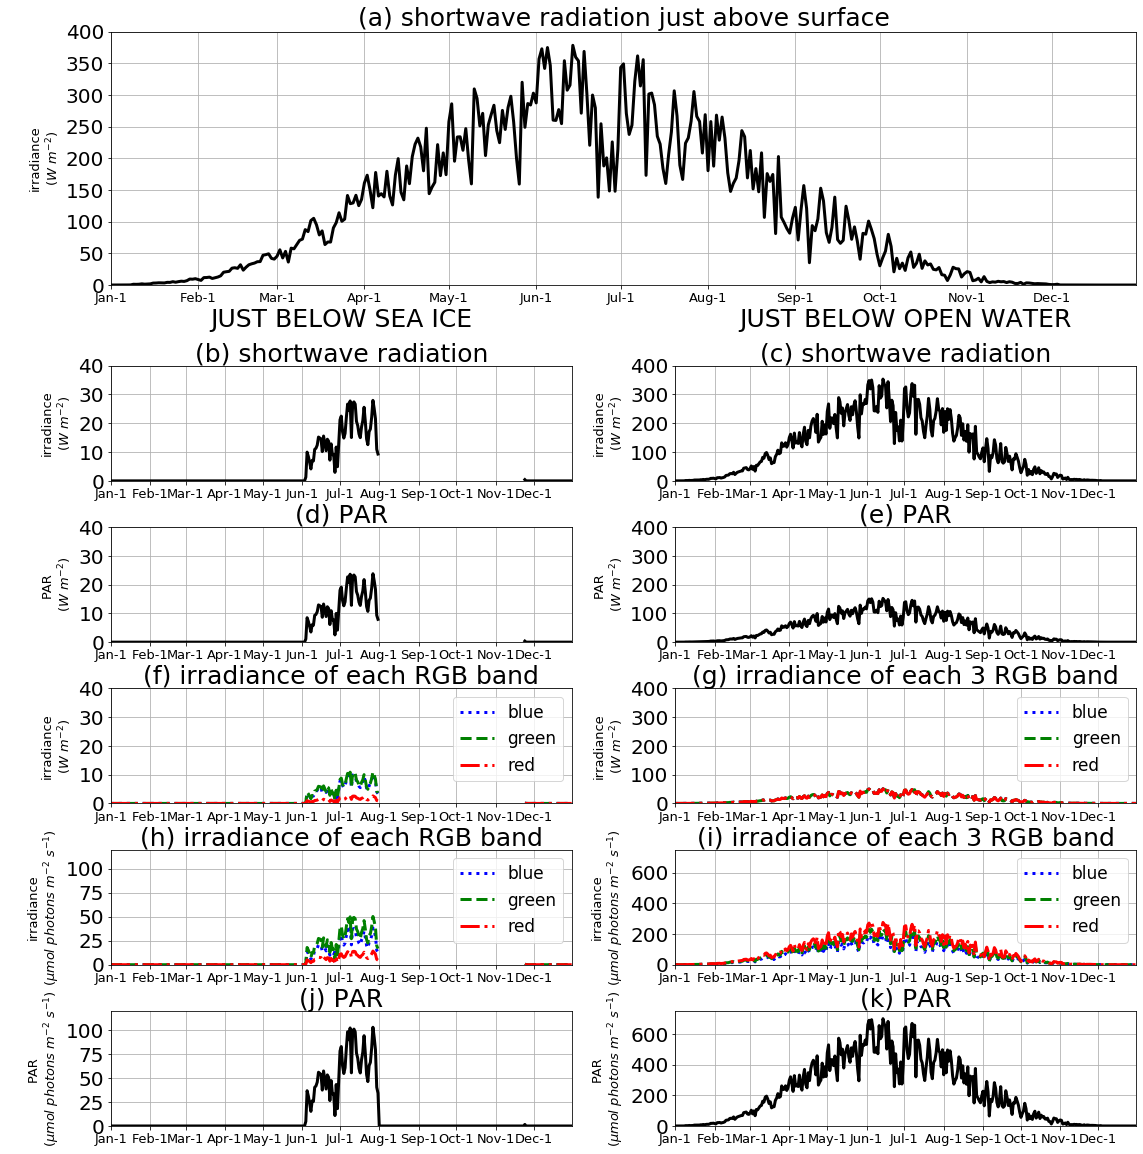

In [22]:
with plt.style.context('par.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    fig,axs=plt.subplots(nrows=6,ncols=2,figsize=(16, 16))
    
    # --- DAILY SHORTWAVE RADIATION JUST ABOVE SURFACE IN 2016
    ax=axs[0,0]
    ax.plot(first_year,array1d_idoy_qswowabove,color='black',lw=3)
    ax.set_ylabel('irradiance\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.05,
             '(a) shortwave radiation just above surface',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- BLANK
    ax=axs[0,1]
    ax.axis('off')
    
    # --- DAILY SHORTWAVE RADIATION JUST BELOW SEA ICE FROM 2016
    ax=axs[1,0]
    ax.plot(first_year,array1d_idoy_qswice,color='black',lw=3)
    ax.set_ylabel('irradiance\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,40)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.40,
             'JUST BELOW SEA ICE',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    plt.text(0.50,1.10,
             '(b) shortwave radiation',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY SHORTWAVE RADIATION JUST BELOW OPEN WATER IN 2016
    ax=axs[1,1]
    ax.plot(first_year,array1d_idoy_qswow,color='black',lw=3)
    ax.set_ylabel('irradiance\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.40,
             'JUST BELOW OPEN WATER',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    plt.text(0.50,1.10,
             '(c) shortwave radiation',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW SEA ICE IN 2016
    # --- W m^-2
    ax=axs[2,0]
    ax.plot(first_year,array1d_idoy_PARice,color='black',lw=3)
    ax.set_ylabel('PAR\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,40)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(d) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW OPEN WATER IN 2016
    # --- W m^-2
    ax=axs[2,1]
    ax.plot(first_year,array1d_idoy_PARow,color='black',lw=3)
    ax.set_ylabel('PAR\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(e) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW SEA ICE IN 2016
    # --- W m^-2
    ax=axs[3,0]
    ax.plot(first_year,array1d_idoy_blueWm2,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_greenWm2,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_redWm2,
                  '-.',color='red',lw=3,label='red')
    ax.legend()
    ax.set_ylabel('irradiance\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,40)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(f) irradiance of each RGB band',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW OPEN WATER IN 2016
    # --- W m^-2
    ax=axs[3,1]
    ax.plot(first_year,array1d_idoy_blueWm2ow,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_greenWm2ow,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_redWm2ow,
                  '-.',color='red',lw=3,label='red')
    ax.legend()
    ax.set_ylabel('irradiance\n'\
                  '$(W\ m^{-2})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(g) irradiance of each 3 RGB band',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW SEA ICE IN 2016
    # --- umol photons m^-2 s^-1
    ax=axs[4,0]
    ax.plot(first_year,array1d_idoy_blue,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_green,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_red,
                  '-.',color='red',lw=3,label='red')
    ax.legend()
    ax.set_ylabel('irradiance\n'\
                  '$(\mu mol\ photons\ m^{-2}\ s^{-1})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,120)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(h) irradiance of each RGB band',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW OPEN WATER IN 2016
    # --- umol photons m^-2 s^-1
    ax=axs[4,1]
    ax.plot(first_year,array1d_idoy_blueow,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_greenow,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_redow,
                  '-.',color='red',lw=3,label='red')
    ax.legend()
    ax.set_ylabel('irradiance\n'\
                  '$(\mu mol\ photons\ m^{-2}\ s^{-1})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,750)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(i) irradiance of each 3 RGB band',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW SEA ICE IN 2016
    # --- umol photons m^-2 s^-1
    ax=axs[5,0]
    ax.plot(first_year,array1d_idoy_PARiceuEin,color='black',lw=3)
    ax.set_ylabel('PAR\n'\
                  '$(\mu mol\ photons\ m^{-2}\ s^{-1})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,120)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(j) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW OPEN WATER IN 2016
    ax=axs[5,1]
    ax.plot(first_year,array1d_idoy_PARowuEin,color='black',lw=3)
    ax.set_ylabel('PAR\n'\
                  '$(\mu mol\ photons\ m^{-2}\ s^{-1})$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,750)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(k) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- POSITION
    axs[0,0].set_position( [0.10,0.75  ,0.89,0.22])
    axs[0,1].set_position( [0.01,0.01  ,0.01,0.01])
    axs[1,0].set_position( [0.10,0.58  ,0.40,0.10])
    axs[1,1].set_position( [0.59,0.58  ,0.40,0.10])
    axs[2,0].set_position( [0.10,0.44  ,0.40,0.10])
    axs[2,1].set_position( [0.59,0.44  ,0.40,0.10])
    axs[3,0].set_position( [0.10,0.30  ,0.40,0.10])
    axs[3,1].set_position( [0.59,0.30  ,0.40,0.10])
    axs[4,0].set_position( [0.10,0.16  ,0.40,0.10])
    axs[4,1].set_position( [0.59,0.16  ,0.40,0.10])
    axs[5,0].set_position( [0.10,0.02  ,0.40,0.10])
    axs[5,1].set_position( [0.59,0.02  ,0.40,0.10])
    
    # --- SAVE
    plt.savefig('par.png')